# One-vs-all logistic regression model

## Single logistic regression cell

**Notation:**

- $\theta_{j}$: weights, $j=1,...,n$
- $x^{(i)}_{j}$: the $j$-th feature of the $i$-th sample, $i=1,..,m$, $j=1,...,n$
- $y^{(i)}$: $i$-th label, $i=1,..,m$


**Vectorized form:**

\begin{equation}
    X
    =
    \begin{bmatrix}
    -- (x^{(1)})^{T} -- \\
    -- (x^{(2)})^{T} -- \\
    ... \\
    -- (x^{(m)})^{T} --
    \end{bmatrix}
\end{equation}


\begin{equation}
    \theta
    =
    \begin{bmatrix}
    \theta_{1} \\
    \theta_{2} \\
    ... \\
    \theta_{m}
    \end{bmatrix}
\end{equation}

\begin{equation}
    y
    =
    \begin{bmatrix}
    y^{(1)} \\
    y^{(2)} \\
    ... \\
    y^{(m)}
    \end{bmatrix}
\end{equation}

**Dimensions:**
- $m$: number of samples
- $n$: number of weights

### Model:

Logistics function:

\begin{equation}
    h_{\theta}(x^{(i)})
    =
    \sigma(\theta^{T} x^{(i)})
    =
    \frac{1}{1 + e^{- \theta^{T} x^{(i)} }}
\end{equation}

where $\sigma(z)$ is the sigmoid function:

\begin{equation}
    \sigma(z)
    =
    \frac{1}{1 + e^{-z}}
\end{equation}

We wish to achive:

\begin{equation}
h_{\theta}(x^{(i)}) \simeq y^{(i)}
\end{equation}

### Cost function

\begin{equation}
    J(\theta)
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        -y^{(i)} \log( h_{\theta}(x^{(i)}) - (1-y^{(i)}) \log(1-h_{\theta}(x^{(i)})
    \right]
    +
    \frac{\lambda}{2m}
    \sum_{j=1}^{n}
    \theta^{2}_{j}
\end{equation}

### Gradient

The $j=0$ component:

\begin{equation}
    \frac{\partial J}{\partial \theta_{j}}
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        (
        h_{\theta} (x^{(i)})
        -
        y^{(i)}
        )
        x^{(i)}_{j}
    \right]
\end{equation}

$j \neq 0$ components:

\begin{equation}
    \frac{\partial J}{\partial \theta_{j}}
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        (
        h_{\theta} (x^{(i)})
        -
        y^{(i)}
        )
        x^{(i)}_{j}
    \right]
    +
    \frac{\lambda}{m} \theta_{j}
\end{equation}

Vectorized form:

\begin{equation}
    \underline{\theta}'
    =
    \begin{bmatrix}
        0 \\
        \theta_{1} \\
        \theta_{2} \\
        ... \\
        \theta_{n}
    \end{bmatrix}
\end{equation}

\begin{equation}
    \nabla_{\theta} J
    =
    \frac{1}{m}
    \underline{\underline{X}}^{T}
    (
        \underline{h_{\theta}}(x)
        -
        \underline{y}
    )
    +
    \frac{\lambda}{m}
    \underline{\theta'}
\end{equation}

In [31]:
import scipy.io
from scipy import optimize

In [163]:
print(np.__version__)
print(scipy.__version__)

1.13.1
0.19.1


In [32]:
data = scipy.io.loadmat('ex3data1.mat')

In [33]:
features = data['X']
labels = data['y'][:,0]
X = np.insert(data['X'], 0, 1, axis=1)
y = data['y'][:,0]

In [127]:
def show_digit(flat_pixels):
    img = flat_pixels.reshape([20,20])
    img_rot = np.rot90(img)
    plt.imshow(img_rot, cmap='gray_r', origin='lower');

### Examples

[10]


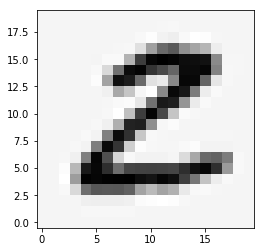

In [125]:
show_digit(data['X'][1012]);
print(data['y'][0])

[10]


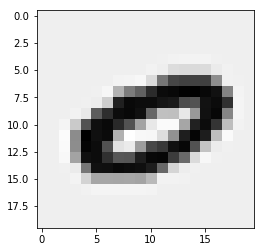

In [126]:
show_img(data['X'][]);
print(data['y'][2])

### Function definitions

In [49]:
def sigmoid(z):
    s = 1.0 / ( 1.0 + np.exp(-z) )
    return s

Hypothesis:

\begin{equation}
    h_{\theta}(x^{(i)})
    =
    \sigma(\theta^{T} x^{(i)})
    =
    \frac{1}{1 + e^{- \theta^{T} x^{(i)} }}
\end{equation}

In [44]:
def hypothesis(theta,X):
    z = X.dot(theta)
    h = sigmoid(z)
    return h

Cost function:

\begin{equation}
    J(\theta)
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        -y^{(i)} \log( h_{\theta}(x^{(i)}) - (1-y^{(i)}) \log(1-h_{\theta}(x^{(i)})
    \right]
    +
    \frac{\lambda}{2m}
    \sum_{j=1}^{n}
    \theta^{2}_{j}
\end{equation}

In [51]:
def cost_function(theta, X, y, lam=0):
    """ theta: nx1
        X: mxn
        theta: nx1
        lam: 1
    """
    m = len(X)
    h = hypothesis(theta, X)
    cost_vector = -y * np.log(h) - (1.0-y)*np.log(1.0 - h)
    regularization_term = np.sum(theta**2) * lam/(2.0*m)
    cost = np.sum(cost_vector)/m + regularization_term
    return cost

Gradient:

\begin{equation}
    \frac{\partial J}{\partial \theta_{j}}
    =
    \frac{1}{m}
    \sum_{i=1}^{m}
    \left[
        (
        h_{\theta} (x^{(i)})
        -
        y^{(i)}
        )
        x^{(i)}_{j}
    \right]
    +
    \frac{\lambda}{m} \theta_{j}
\end{equation}

In [174]:
def gradient(theta, X, y, lam=0):
    """- X: mxn
       - y: mx1
       - theta: nx1
       - lam: 1"""
    m = len(X)
    h = hypothesis(theta,X)
    thetap = theta
    thetap[0] = 0
    gradient = (X.transpose().dot(h-y) + lam*thetap)/m
    return gradient

In [215]:
def accuracy(yreal, ypred):
    m = len(yreal)
    correct = 0
    for yr, yp in zip(yreal,ypred):
        if np.abs(yr-yp) <= 0.5:
            correct += 1
        else:
            pass
            
    accuracy = correct/m
    return accuracy

## Single class logistic regression

Train on a specific digit

In [193]:
digit = 2

Create target vector

In [194]:
y = (labels == digit).astype(int)

In [195]:
index = np.where(y == 1)[0][100]

In [196]:
index

1100

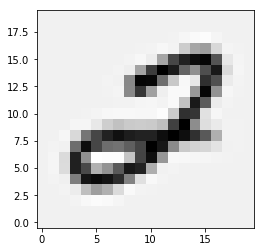

In [197]:
show_digit(data['X'][index]);

In [198]:
theta = np.random.uniform(high=0.5, size=401)

In [199]:
cost_function(theta, X, y)

11.626218741454798

In [200]:
gradient(theta,X,y,lam=0.0)

array([  8.99803664e-01,   0.00000000e+00,   0.00000000e+00,
         1.54829924e-07,  -1.93726772e-06,  -2.94567187e-06,
         1.23105890e-04,   1.47743864e-04,   8.05782869e-05,
         1.93994135e-05,   4.36192125e-05,   1.41025418e-05,
        -1.08465974e-05,  -2.36774995e-05,  -4.05773460e-05,
        -5.65730514e-05,  -4.14585046e-05,  -1.40553512e-05,
        -9.27395079e-08,   1.46377947e-07,   0.00000000e+00,
         4.93600154e-08,  -4.03749987e-07,  -1.86934790e-06,
        -2.57175673e-06,  -2.55787362e-05,   1.28867959e-04,
         6.10543332e-04,   9.16260798e-04,   7.18056439e-04,
         2.74088862e-04,  -8.94500929e-05,  -1.67486460e-04,
        -9.96312725e-05,  -3.99614659e-05,   9.47686302e-05,
         9.10514765e-05,  -2.81309192e-06,  -4.85486709e-05,
        -8.31142393e-06,  -1.77153611e-06,  -4.23443750e-07,
         3.82615143e-06,  -1.64538154e-05,   1.81646877e-04,
         8.83611115e-04,   2.52361846e-03,   4.44916249e-03,
         5.36227880e-03,

In [201]:
theta0 = np.random.uniform(high=0.1, size=401)

In [202]:
h = hypothesis(theta0, X)

In [203]:
h.mean()

0.90859954909637397

In [204]:
g = gradient(theta0, X, y, lam=0)

### Optimization

Minimize a function using a nonlinear conjugate gradient algorithm, `fmin_cg`

In [205]:
lam = 0

In [ ]:
def save_cost_function_val_callback():
    

In [235]:
theta_opt, theta_iters = optimize.fmin_cg(f=cost_function, fprime=gradient, x0=theta0, args=(X, y, lam), maxiter=50, retall=True)

         Current function value: 0.052079
         Iterations: 50
         Function evaluations: 147
         Gradient evaluations: 147


In [207]:
y_predicted = hypothesis(theta_opt,X)

In [228]:
len(f_opt)

51

### Evolution of cost function 

In [236]:
costs = [cost_function(theta, X, y, lam) for theta in theta_iters]

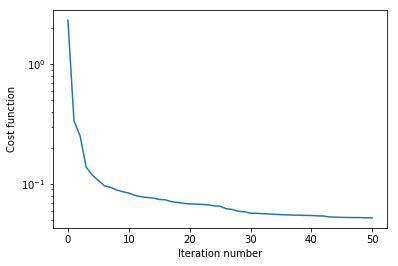

In [237]:
f,a = plt.subplots()
a.plot(costs)
a.set_yscale('log')
a.set_xlabel('Iteration number')
a.set_ylabel('Cost function')

### Accuracy

In [238]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [239]:
y_predicted

array([  5.78506129e-05,   1.48696208e-06,   3.29719278e-04, ...,
         1.40336717e-03,   9.60171427e-11,   1.05317145e-07])

In [240]:
accuracy(y, y_predicted)

0.9854

## Test area

Nelder-Mead minimization

In [176]:
optim = optimize.minimize(fun=cost_function, x0=theta0, args=(X, y, lam), method=None, maxiter=50)

TypeError: minimize() got an unexpected keyword argument 'maxiter'